<a href="https://colab.research.google.com/github/davidmterneriu/E673_PS2_SP21/blob/main/linkprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Let's predict some links (David Terner)**
-- 


[Github Link](https://github.com/davidmterneriu/SP22_I606_linkprediction/blob/main/linkprediction.ipynb)

**Why do we care about link prediction?** 

This assignment will help you understand the link prediction task, which is one of the most common machine learning tasks that involve networks.

Link prediction problem is everywhere. For instance, recommendation problems (e.g., Netflix) are link prediction. When you open up Netflix, it suggests you a whole bunch of shows and movies that you may like. In this setting, all users and contents on Netflix can be considered as a bipartite network and the link prediction task is to predict the link between contents and a given user.

Similarly, link prediction is heavily used in all social media and social networking services like Facebook, Twitter, LinkedIn, and so on. To make users engaged with the platform, they constantly suggest new users or new topics to follow.

**How can we do that?**

There are roughly two ways to approach this problem. First, we can look at every pair of candidate node pairs and the local network structure around them to calculate certain metrics that inform the likelihood of a link between two candidates. For instance, if two people have many common friends, maybe they already know each other. Another way to think about this is considering a list of features (characteristics) that a node has (independent of other nodes) and then use the features of two nodes to compute the likelihood of having a link. For instance, if two people have so many common interests, they may already know each other or they will quickly become friends. In other words, both of these thinking leverages the strong homophily (and the clustered structure produced by it) to predict missing links.

The most extreme (?) version of node-feature-based approach may be using graph embedding or graph neural networks. Graph embedding learns a vector for each node based on network structure and these vectors become nodes' features. We can perform link prediction by simply calculating the similarity between these vectors. Graph neural networks move further by incorporating existing node features on top of the network structure.

**Overview**

For this assignment, you will use Cora dataset which is a network of research papers that are connected by citations. You will build a Node2Vec model to predict citation links between different research papers.

You will create a binary classification model to predict links/edges on top of node embeddings. Note that the link prediction (binary classification) is a *supervised* task whereas the learning node representations (embedding) is an *unsupervised* (or self-supervised) task.

Please consider reading Node2Vec: Scalable Feature Learning for Networks research paper for exploring underlying concepts to complete this assignment. 

We will use ```stellergraph``` package to import dataset and related functions.

In [1]:
!pip install stellargraph

Let's import a bunch of stuff that we will need first.

In [2]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

**Loading Cora dataset**

You will use ```stellargraph.datasets.Cora()``` to get the paper citation network dataset. Use ```load``` function of the dataset to load the dataset. Use ```largest_connected_component_only``` to load the largest connected component only and ```str_node_ids``` for making node IDs as string.

In [3]:
dataset = datasets.Cora()
dataset.description

'The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.'

In [4]:
graph, _ = dataset.load(largest_connected_component_only=True, str_node_ids=True)
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


**Splitting Network Data into Train/Test**

Here, you will create two models (Node embedding model and Binary classification model) and that is why you will require two types of datasets. You will need to transform original dataset into two datatsets.

For training node embedding model, you need train and test graph (denoted by ```graph_train``` and ```graph_test``` in assignment) which will be the subgraph of original network.

For training edge classifier model, you need training and test dataset (denoted by ```examples_train``` and ```examples_test``` in assignment) containing positive-negative edges.

You also will need another split of edges dataset in order select the best classifier model. We are describing it as ```examples_validation```.

You can use ```EdgeSplitter``` class from ```stellargraph``` to split dataset. You can use ```train_test_split``` function from ```EdgeSplitter``` object.

**Generating Test data** 

For link prediction task, you need to hide (remove) links from the original graph. Those edges will be called positive edges and you will take some random edges between nodes which doesn't have any edge between them in original graph. Those edges are called negative edges.

You don't need to write your own function. ```train_test_split()``` from ```EdgeSplitter does``` that for us.

Before you split the actual ```Cora``` dataset graph, we have provided an example graph for you to visualize and understand how ```train_test_split``` works.

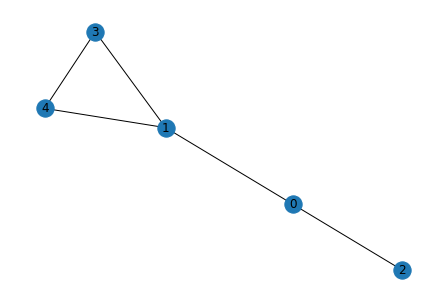

In [5]:
G = nx.Graph()
G.add_edges_from([(0, 1), (0,2), (1, 3), (3, 4), (1,4)])

nx.draw(G, with_labels=True)

Now, let's remove 20% of the edges from the example graph. Note that above example graph contains 5 edges. So, if you remove 20% of edges in this graph, it will remove 1 edge.

** Sampled 1 positive and 1 negative edges. **


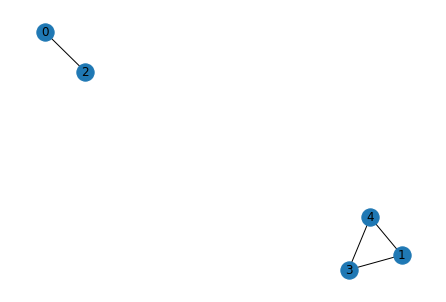

In [6]:
# Edge splitter object for example graph
splitter_example = EdgeSplitter(G)

# Use train_test_split from splitter_example to get sampled edges, labels and test graph.
graph_example, example_edges, example_labels = splitter_example.train_test_split(p=0.2)

nx.draw(graph_example, with_labels=True)

You can see that one of the edge from the graph is removed. If you look at the other return values, you can see that the ```example_edges``` variable contains two (there will be more in a larger graph) example edges and their labels. They contain both positive and negative examples.

In [7]:
print(example_edges)
print(example_labels)

[[0 1]
 [1 2]]
[1 0]


From above print statement, it is clear that it has extracted two edges from the graph among which one is positive edge (```label=1```) and another is negative edge (```label=0```). So, this is how train_test_split function works.

Now, let us split the graph for Cora dataset.

You need to remove 10% of edges from the original graph to get our test graph. Also, make sure that you sample the negative edges from global structure of graph. (These will be parameters in the function ```train_test_split```)

In [8]:
# Edge splitter test object for original graph
splitter_test = EdgeSplitter(graph)

# TODO: Use train_test_split from splitter_test to get sampled edges, labels and test graph.
# graph_test, examples_test, labels_test = ... 

graph_test, examples_test, labels_test = splitter_test.train_test_split(p=0.1)

print(graph_test.info())

** Sampled 520 positive and 520 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 4689

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4689]
        Weights: all 1 (default)
        Features: none


**Generating Test Data** 

```graph_test``` extracted above has 10% edges (positive edges) removed from the original graph. Same number of negative edges are also sampled from original graph.

Now, you have to get training dataset. To do that, you can sample 10% positive-negative edges from ```graph_test``` (if we use ```graph``` for sampling training data, then there may be some edges which overlap in ```graph_test``` data which will defeat the purpose of test data being non-overlapping with train data). You need to follow same code which you followed previously.

After you get ```examples``` from ```splitter_train.train_test_split()```, you will need to apply ```sklearn.model_selection.train_test_split()``` to divide training dataset into train and validation dataset in 3:1 ratio.

In [9]:
# Edge splitter train object for graph_test
# Note that we are also passing original graph here since we don't want EdgeSplitter to
# sample negative edge from graph_test which was removed as part of previous split.
splitter_train = EdgeSplitter(graph_test, graph)

# TODO: Use train_test_split from splitter_train to get sampled edges, labels and train graph.
# graph_train, examples, labels = ... 
graph_train, examples, labels =splitter_train.train_test_split()

# Use sklearn.model_selection.train_test_split() on examples and labels to get train and validation edge data.
#examples_train, examples_validation, labels_train, labels_validation = train_test_split(train_size=0.75, test_size=0.25)

examples_train, examples_validation, labels_train, labels_validation = train_test_split(
    examples, labels, train_size=0.75, test_size=0.25
)

print(graph_train.info())

** Sampled 2344 positive and 2344 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 2345

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [2345]
        Weights: all 1 (default)
        Features: none


In [10]:
print("Number of edges in Train dataset: {}".format(len(examples_train)))
print("Number of edges in Validation dataset: {}".format(len(examples_validation)))
print("Number of edges in Test dataset: {}".format(len(examples_test)))

Number of edges in Train dataset: 3516
Number of edges in Validation dataset: 1172
Number of edges in Test dataset: 1040


Now, you have all the datasets you need to proceed for model building task.

**Simplest Node Representations**

If you want to represent a particular node in a graph with a vector of certain length, the simplest possible representation of that graph is the row of adjacency matrix corresponding to that particular node.

Let us understand this by the example graph $G$ that we created previously.

In [11]:
# Creating adjacency matrix of graph G
print(nx.to_numpy_matrix(G))

[[0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0.]]


Each row in the above matrix represents a node and the row contains ```1``` where edge exists between this node with the other node else ```0```. The row contains ```5``` elements at the moment since we have ```5``` nodes in the graph. If the graph has $N$ nodes then this type of representation will have length $N$ for each node representation. Moreover, if two nodes do not share any neighbors, the two feature vectors (the rows or columns that correspond to the nodes) will be orthogonal and we will not be able to obtain meaningful similarity measure between them.

Because the graph can be pretty huge, this type of node representation is not scalable. It does not only require a lot of space to store, it will not give us any meaningful way to compute similarity between most pairs of nodes. This is why we want to either use measures that take local network structure into account or *dense* representations.

**Adamic Adar Index** 

Adamic Adar is also one of the simplest edge representation techniques. It focuses on the common neighbors of the two nodes that we are considering. The idea is that if two nodes have many shared neighbors who do not have many neighbors, the two nodes should be more likely to be connected.

You will use example graph $G$ to find Adamic Adar index its edges. Use simple ```adamic_adar_index``` method from ```networkx``` to find it.

[(0, 3, 0.9102392266268373), (0, 4, 0.9102392266268373), (1, 2, 1.4426950408889634), (2, 3, 0), (2, 4, 0)]


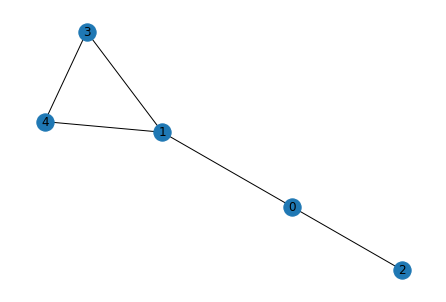

In [12]:
# TODO: Find adamic adar index of all possible edges in graph G
edge_indexes = nx.adamic_adar_index(G)

nx.draw(G, with_labels=True)
print(list(edge_indexes))

In above index list, all elements are in form ```(u, v, p)``` where ```u``` and ```v``` are the node pairs where there may be a missing link. And ```p``` represents the index found through the algorithm. Note that (2,3) and (2,4) have 0 as they do not share any common neighbors.

Now, these numbers can be used as a feature for any given pair of nodes and can be inputted to other models (e.g., logistic regression).

Although it is a useful heuristic measure that can be used as a baseline, note that it is only a single number and it cannot compute the score if two nodes do not share any neighbors.

**DeepWalk/Node2Vec**

DeepWalk and Node2vec are two of the first graph embedding models that are inspired by the word2vec model. The idea is super simple. We consider random walk trajectories on a graph as "sentences"! The node ids appearing in the random walks are then considered as "words".

You will create a Node2Vec model which will create low dimensional node representations. These node embeddings will be created by the model such that the nodes which are closer in the graph will have embeddings closer (more cosine similarity).

In Node2Vec model, it first makes random walks through the node and finds context pairs. You can use ```BiasedRandomWalk``` to do that. Once you have random walk data, you can pass the walks data to Word2Vec model. Just like Word2Vec generates embedding for words, it will generate for the random walks you will pass. You don't need to create Word2Vec model from scratch. You can use ```Word2Vec``` from gensim package.


Below are the parameters used in Node2Vec model. To understand more about the parameter, please consider reading Node2Vec paper.
* ```p``` - Random walk parameter “p” 
* ```q``` - Random walk parameter “q”
* ```dimensions``` - Dimensionality of node2vec embeddings
* ```num_walks``` - Number of walks from each node
* ```walk_length``` - Length of each random walk
* ```window_size``` - Context window size for Word2Vec
* ```num_iter``` - number of SGD iterations (epochs)
* ```workers``` - Number of workers for Word2Vec

To stay consistent with the results, we have initialized the paramters in this assignment. Please do not change the paramters for submission but if you want to experiment with the model, you can.

In [13]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()

In [14]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec

def node2vec_embedding(graph, graph_name):
    # Object to generate random walks
    random_walker = BiasedRandomWalk(graph)

    # Generate random walks for graph using random_walker
    walks = random_walker.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print('Number of random walks for "{}": {}'.format(graph_name, len(walks)))

    # TODO: Create model using Word2Vec imported from gensim.models
    model = Word2Vec(walks, workers=workers, window =window_size, size=dimensions,iter=num_iter)

    # Get embedding of a node
    def get_embedding(u):
        return model.wv[u]
    
    return get_embedding

In [15]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for "Train Graph": 24850


In [16]:
l1=list(graph_train.nodes())
embedding_train(l1[0])

array([ 0.36790746, -0.32776412, -0.14890736, -0.09989811,  0.18234122,
        0.41340598,  0.1687093 ,  0.31811896,  0.03253543, -0.04996674,
       -0.08796624,  0.46507722,  0.3878785 , -0.08070821,  0.07919607,
       -0.02992574, -0.63252264, -0.45156357, -0.14279704, -0.4188826 ,
       -0.310355  , -0.18535928,  0.41045493,  0.15183869,  0.429509  ,
       -0.16995099,  0.6925275 , -0.00607513, -0.06731043,  0.07796215,
       -0.28683323, -0.10521615, -0.19490585,  0.30767477, -0.2549857 ,
        0.37774876, -0.34241593,  0.11385491, -0.12831508, -0.02632803,
        0.10319228,  0.20431837,  0.03765787,  0.34806123, -0.01710514,
        0.12106306, -0.19269873,  0.45752376, -0.13470285, -0.00433778,
        0.03937035,  0.33772635, -0.05828411,  0.1482854 ,  0.45397034,
        0.57467824, -0.02440714,  0.41763663, -0.07819781,  0.26249105,
        0.17059807, -0.37077224,  0.32928118,  0.4516231 ,  0.24086894,
       -0.6011995 , -0.02081092,  0.4023646 , -0.10935867, -0.12

**Training & Evaluating the link prediction model**

There are few steps involved in using Word2Vec model to perform link prediction.

1. Calculate link embeddings of positive and negative edges by applying binary operator to embeddings of source and destination nodes of particular edge.
2. From the link embeddings found in previous step, train the logistic regression classifier to predict binary values (positive or negative edge).
3. Evaluate performance of classification model for 4 different binary operators.
4. Use best classifier on test data and find node embeddings on test graph.
Let us first implement the binary operators for you so that you don't have to worry about their implementation. You just need to use it. Below are 4 binary operators mentioned in the original Node2Vec paper:

* Hadamard
* L1
* L2
* Average

In [17]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0

Now, you will implement functions to classify edges and some helper functions to do that. You can use above operator functions wherever you need to.

For your flexibility, you don't need to write a whole function, you just need to complete the function in the given boilerplate.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Step 1: Finding Edge embeddings for all edges
def edge_examples_to_embeddings(edges_examples, transform_node, binary_operator):
    """
    Args:
        edges_examples: list containing tuples of nodes (src, dest) containing edge information
        transform_node: function to find node embedding by just passing node index
        binary_operator: function which takes node embeddings of two nodes and finds edge embedding
    
    Returns: list containing edge embeddings for all edges in edges_examples
    """
    edge_embeddings = []
    # TODO: Iterate over edge_examples and apply binary operator on node embeddings to get edge embeddings
    for src, dest in edges_examples:
      p1=binary_operator(transform_node(src),transform_node(dest))
      edge_embeddings.append(p1)
    return edge_embeddings


# Step 2: Training edge prediction model
## Define function to create classifier model using LogisticRegressionCV
## See https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html 
def edge_prediction_classifier(max_iter=2000):
    """
    We have defined this function for you. Understand how it works.
    """
    clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", clf)])

## Define function to create and train classifier model
def train_edge_prediction_model(edges_examples, edge_labels, transform_node, binary_operator):
    """
    Args:
        edges_examples: list containing tuples of nodes (src, dest) containing edge information
        edge_labels: list containing labels (0/1) for edges denoting whether the edge is positive or negative
        transform_node: function to find node embedding by just passing node index
        binary_operator: function which takes node embeddings of two nodes and finds edge embedding
    
    Returns: Trained classifier model
    """
    # Use edge_prediction_classifier function to create model pipeline. 
    clf = edge_prediction_classifier()

    # TODO: Use edge_examples_to_embeddings to find edge embeddings for edges_examples
    edge_embeddings = edge_examples_to_embeddings(edges_examples, transform_node, binary_operator)
    
    # TODO: Train classifier using fit() method of clf. 
    clf.fit(edge_embeddings,edge_labels)
    
    
    return clf


# Step 3 & 4: Evaluate classifier for all binary operators
## Define function to calculate ROC score of prediction
def evaluate_roc_auc(clf, edge_embeddings,edge_labels):
    """
    Args:
        clf: trained classifier model
        edge_embeddings: list containing embeddings of edges
        edge_labels: list containing edge labels (0/1)
    
    Returns: ROC score for all edges in edge_embeddings
    """
    # TODO: Find predictions of edge_embeddings using predict_proba(). 
    # Refer the documentation to learn how you use it. 
    predicted = clf.predict_proba(edge_embeddings)

    # Find the column index which corresponds to positive edges (label=1) from clf.classes_
    positive_column = list(clf.classes_).index(1)

    return roc_auc_score(edge_labels, predicted[:, positive_column])

## Evaluate classifier model on test data to find ROC score
def evaluate_edge_prediction_model(clf, edges_examples, edge_labels, transform_node, binary_operator):
    """
    Args:
        clf: trained classifier model
        edge_examples: list containing tuples of nodes (src, dest) containing edge information
        edges_labels: list containing labels (0/1) for edges denoting whether the edge is positive or negative
        transform_node: function to find node embedding by just passing node index
        binary_operator: function which takes node embeddings of two nodes and finds edge embedding
    
    Returns: ROC score of predictions on data
    """
    # TODO: Use edge_examples_to_embeddings to find edge embeddings for test_edge_examples
    test_edge_examples=edge_examples_to_embeddings(edges_examples,transform_node, binary_operator)
    
    # TODO: Use evaluate_roc_auc to find ROC score for test data
    score = evaluate_roc_auc(clf,edge_embeddings=test_edge_examples,edge_labels=edge_labels)
    
    return score

Well Done! You have defined all the functions needed for creating and evaluating link prediction model. Now, you will create a function to run the experiments for all binary operators to decide that classifier corresponding to which binary operator performs best.

Before you do that, remember that you already have train (```examples_train``` & ```labels_train```), validation (```examples_validation``` & ```labels_validation```) and test (```examples_test``` & ```labels_test```) datasets created. Also, you have ```embedding_train``` function which takes argument as node index and finds node embedding. You will need to use all above things in the below function.

In [19]:
def run_edge_prediction(binary_operator):
    """
    This function will run the experiment for particular binary operator function
    and will return the details about the experiment.
    """
    # TODO: Use train_edge_prediction_model to create & train classifier model on training dataset
    clf = train_edge_prediction_model(edges_examples=examples_train,
                                      edge_labels=labels_train,
                                      transform_node=embedding_train,
                                      binary_operator=binary_operator)

    # TODO: Use evaluate_edge_prediction_model to find the ROC score above trained model
    # Note that you will use validation data to find the ROC score and not train data
    score =evaluate_edge_prediction_model(clf,
                                          edges_examples=examples_validation,
                                          edge_labels=labels_validation,
                                          transform_node=embedding_train,
                                          binary_operator=binary_operator)
    
    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score
    }

Now is the time to run above function for all binary operator functions that we have given earlier.

In [20]:
binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

results = []

for op in binary_operators:
    # TODO: Execute run_edge_prediction for all binary operators and put in results
    results.append(run_edge_prediction(op))

In [21]:
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

Best result from 'operator_hadamard'


In [22]:
for res in results:
    print("Score for '{}': {}".format(res['binary_operator'].__name__, res['score']))

Score for 'operator_hadamard': 0.7062662349008142
Score for 'operator_l1': 0.5958951181726053
Score for 'operator_l2': 0.5963523162762525
Score for 'operator_avg': 0.610135237451805


**Evaluating the best model against test data**

Now you know that the model corresponding to which binary operator performs best. You have to calculate ROC score of model against test data (```examples_test``` & ```labels_test```).

Note that you also will create ```embedding_test``` function to find node embedding of test data since the random walks for test data is different than train data.

In [23]:
# create node embedding function for test graph using node2vec_embedding
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for "Test Graph": 24850


In [24]:
# TODO: Find ROC score of best classifier model on test edges using evaluate_edge_prediction_model
# You may want to use model stored in best_result 
def run_edge_prediction2(binary_operator):
    """
    This function will run the experiment for particular binary operator function
    and will return the details about the experiment.
    """
    # TODO: Use train_edge_prediction_model to create & train classifier model on training dataset
    clf = train_edge_prediction_model(edges_examples=examples_train,
                                      edge_labels=labels_train,
                                      transform_node=embedding_train,
                                      binary_operator=binary_operator)

    # TODO: Use evaluate_edge_prediction_model to find the ROC score above trained model
    # Note that you will use validation data to find the ROC score and not train data
    score =evaluate_edge_prediction_model(clf,
                                          edges_examples=examples_test,
                                          edge_labels=labels_test,
                                          transform_node=embedding_test,
                                          binary_operator=binary_operator)
    
    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score
    }




test_score =run_edge_prediction2(operator_hadamard)

print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_hadamard': {'classifier': Pipeline(steps=[('sc', StandardScaler()),
                ('clf',
                 LogisticRegressionCV(cv=10, max_iter=2000,
                                      scoring='roc_auc'))]), 'binary_operator': <function operator_hadamard at 0x7f8410b37050>, 'score': 0.8301590236686391}


**Visualize Edge Embeddings**

You know that learned embeddings are of 128 dimensions but to visualize, we need to project them into 2 dimensions. This is where ```PCA``` (Principle Component Analysis) or other dimensionality reduction can be useful. Let's quickly see whether we can actually see the seperation between positive and negative samples

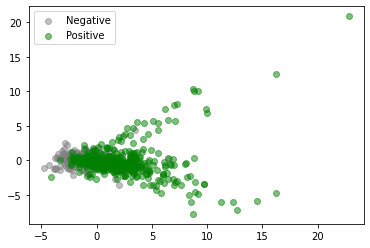

In [25]:
# Get embeddings of edges in test data using edge_examples_to_embeddings
test_edges_embeddings = edge_examples_to_embeddings(examples_test,
                                                    embedding_test,
                                                    best_result["binary_operator"])

# Create PCA object and transform embeddings to 2D data
pca = PCA(n_components=2)
compressed_embeddings = pca.fit_transform(test_edges_embeddings)

# Create scatter plot of the compressed embedding
diff = [(0, 'grey', 'Negative'), (1, 'green', 'Positive')]
fig, ax = plt.subplots()
for label, color, label_name in diff:
    ax.scatter(compressed_embeddings[labels_test == label][:, 0],
               compressed_embeddings[labels_test == label][:, 1], 
               c=color,
               label=label_name,
               alpha=0.5)
ax.legend()
plt.show()